In [1]:
#Set up workspace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
import geopy.distance
import geopandas as gpd
from scipy import stats
import matplotlib.ticker as mticker
import time
import os
from scipy.optimize import curve_fit
import math
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
plt.rcParams['font.size'] = 12

#Turn off the annoying "chained assignment" warning
pd.options.mode.chained_assignment = None 

In [2]:
#Set the matplotlib font globally
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})

In [3]:
os.chdir('/Users/thomashill/Dropbox/Academic/Activities/Articles/Commuting/Fall 2021/Census Files')
msa_blocks = pd.read_csv("MSA_blocks_new.csv")

In [4]:
#Let's fix the Block IDs
new_codes = []
for i in msa_blocks['BLOCKID10']:
    if len(str(i))==14:
        new_code = '0' + str(i)
    else:
        new_code = str(i)
    
    new_codes.append(new_code)

msa_blocks['BLOCKID10'] = new_codes

In [5]:
#Let's create the "occupants" and "worklife ratio" field 
msa_blocks['Occupants'] = msa_blocks['Commuters'] + msa_blocks['POP10']
msa_blocks = msa_blocks[msa_blocks['Occupants']>0]
msa_blocks['Worklife_ratio'] = (msa_blocks['Occupants']-msa_blocks['POP10'])/msa_blocks['Occupants']

#...And from this create the categorical field "Occupancy Category"
occ_cats = []

for i in list(msa_blocks['Worklife_ratio']):
    if i > (2/3):
        cat = 'Work'
    elif i <= (1/3):
        cat = 'Res'
    else:
        cat = 'Mixed'
    
    occ_cats.append(cat)

msa_blocks['Category'] = occ_cats

NOTE: Let's see what this looks like if we just use the MSAs, and not CBSAs. Let's subset MSAs by taking all those CBSAs with population larger than Carson City, NV

In [31]:
msas_summary = msa_blocks.groupby(['CBSA'])

pops = msas_summary.POP10.sum()
commuters = msas_summary.Commuters.sum()
areas = msas_summary.Area_km.sum() 
pop_densities = pops/areas
com_densities = commuters/areas
x_vals = msas_summary.x.mean()
y_vals = msas_summary.y.mean()

msa_summary_df = pd.DataFrame({
    'Pop': pops,
    'Commuters': commuters,
    'Built_Area': areas,
    'Pop_density': pop_densities,
    'Com_density': com_densities,
    'X': x_vals,
    'Y': y_vals})

######
#msa_summary_df = msa_summary_df[msa_summary_df['Pop']>min_pop] 

msa_list = list(msa_summary_df.index)
msa_summary_df['MSA'] = msa_list

msa_summary_df = msa_summary_df.sort_values(by='Pop',ascending=False)
msa_summary_df['Rank'] = range(1,len(msa_summary_df)+1)
msa_summary_df['Rank - Pop'] = range(1,len(msa_summary_df)+1)

msa_pops_dict = dict(zip(msa_summary_df['MSA'],msa_summary_df['Pop']))

#location
msa_x_dict = dict(zip(msa_summary_df['MSA'],msa_summary_df['X']))
msa_y_dict = dict(zip(msa_summary_df['MSA'],msa_summary_df['Y']))

In [32]:
len(msa_list)

911

In [33]:
rank_incs = np.arange(10,920,10)

In [34]:
msa_summary_df = msa_summary_df.sort_values(by='Commuters',ascending=False)
msa_summary_df['Rank - Commuters'] = range(1,len(msa_summary_df)+1)
msa_workers_dict = dict(zip(msa_summary_df['MSA'],msa_summary_df['Commuters']))

In [35]:
pop_slopes = []
work_slopes = []

for inc in rank_incs:
    pop_rank_df = msa_summary_df[msa_summary_df['Rank - Pop'] < inc+1]
    
    x = np.array(pop_rank_df['Rank - Pop'])
    y = np.array(pop_rank_df['Pop'])
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))    
    
    pop_slopes.append(slope)
    
    work_rank_df = msa_summary_df[msa_summary_df['Rank - Commuters'] < inc+1]
    x = list(work_rank_df['Rank - Pop'])
    y = list(work_rank_df['Pop'])    
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))
    
    work_slopes.append(slope)

pop_slopes_df = pd.DataFrame({
    'Rank': rank_incs,
    'Slope': pop_slopes})

work_slopes_df = pd.DataFrame({
    'Rank': rank_incs,
    'Slope': work_slopes})

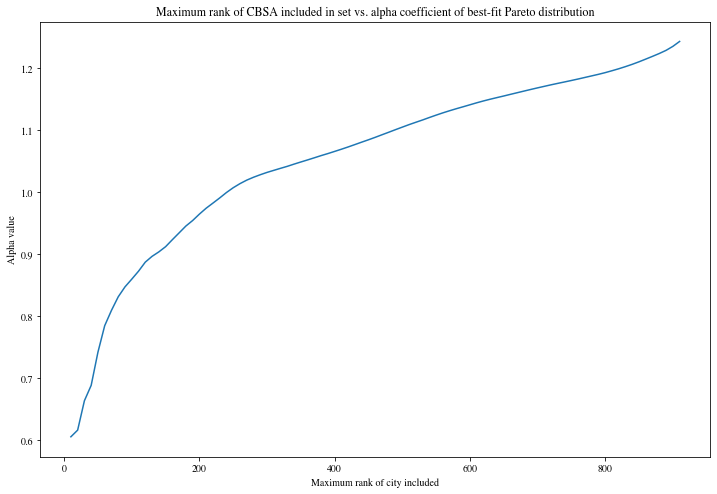

In [36]:
fig,ax = plt.subplots(1,1,figsize=(12,8))

ax.plot(pop_slopes_df['Rank'], -pop_slopes_df['Slope'])
#ax.plot(work_slopes_df['Rank'],work_slopes_df['Slope'])

ax.set_title('Maximum rank of CBSA included in set vs. alpha coefficient of best-fit Pareto distribution')
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_ylim([4*10**(4),10**(8)])
#ax.set_xlim([10**4.9,10**7.5])
ax.set_ylabel('Alpha value')
ax.set_xlabel('Maximum rank of city included')

plt.show()

As we can see, the "best fit" Pareto coefficient alpha decreases monotonically as we increase the rank of the maximum CBSA included in the set. 

In [12]:
#msa_summary_df = msa_summary_df[msa_summary_df['Rank - Pop']<101]
#msa_summary_df = msa_summary_df[msa_summary_df['Rank - Pop']<200]
#msa_summary_df = msa_summary_df[msa_summary_df['Rank - Pop']<301]
#msa_summary_df = msa_summary_df[msa_summary_df['Rank - Pop']<400]
#msa_summary_df = msa_summary_df[msa_summary_df['Rank - Pop']<501]

#### How does population scale with rank?

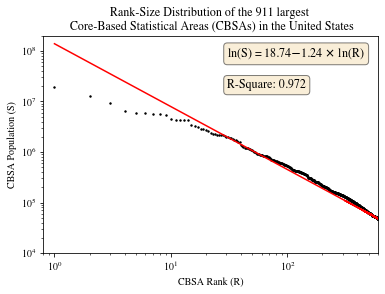

The Pareto distribution fits the national distribution of CSA Populations with an alpha of -1.2438626257500756, a constant C value of 18.744973094083754 and an R-square value of 0.972.


In [37]:
#Plotting
fig,ax = plt.subplots(1,1,figsize=(6,4))

x = list(msa_summary_df['Rank - Pop'])
y = list(msa_summary_df['Pop'])

ax.scatter(x, y, s=2,color='k')

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))    

#Plot the OLS regression line - this will be the Pareto/rank-size relationship
ax.plot(x,np.exp(slope*np.log(x)+intercept),c= "red")

r_sq = round(r_value**2,3)

#display_text = "ln(S) = "  + str(round(intercept,2)) + " - " + str(round(-1*slope,2)) + " x ln(R)"
display_text = "ln(S) = "  + str(round(intercept,2)) + r'$ \minus $' + str(round(-1*slope,2)) + " "+ r'$ \times $' + " ln(R)"

display_text_2 = "R-Square: "+ str(r_sq)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.55, 0.95, display_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.text(0.55, 0.8, display_text_2, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

num_msas = len(msa_summary_df)
plot_title = "Rank-Size Distribution of the "+ str(num_msas) +" largest \n Core-Based Statistical Areas (CBSAs) in the United States"

ax.set_title(plot_title)
#ax.set_title("Rank-Size Distribution of all Combined Statistical Areas (CSAs) in the United States")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([10**(4),2*10**(8)])
ax.set_xlim([0.8*10**0,5*10**2+100])
ax.set_ylabel('CBSA Population (S)')
ax.set_xlabel('CBSA Rank (R)')

plt.show()

print("The Pareto distribution fits the national distribution of CSA Populations with an alpha of " + str(slope) +', a constant C value of '+ 
     str(intercept) + ' and an R-square value of ' + str(r_sq) + '.')


In [14]:
#msa_summary_df = msa_summary_df[msa_summary_df['Rank - Commuters']<101]
#msa_summary_df = msa_summary_df[msa_summary_df['Rank - Pop']<200]
#msa_summary_df = msa_summary_df[msa_summary_df['Rank - Pop']<301]
#msa_summary_df = msa_summary_df[msa_summary_df['Rank - Pop']<400]
#msa_summary_df = msa_summary_df[msa_summary_df['Rank - Pop']<501]

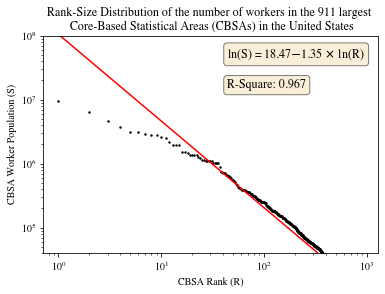

The Pareto distribution fits the national distribution of CBSA Worker Populations with an alpha of -1.3547285612601816, a constant C value of 18.4660325549074 and an R-square value of 0.967.


In [38]:
#Plotting
fig,ax = plt.subplots(1,1,figsize=(6,4))

x = list(msa_summary_df['Rank - Commuters'])
y = list(msa_summary_df['Commuters'])

ax.scatter(x, y, s=2,color='k')

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))    

#Plot the OLS regression line - this will be the Pareto/rank-size relationship
ax.plot(x,np.exp(slope*np.log(x)+intercept),c= "red")

r_sq = round(r_value**2,3)

#display_text = "ln(S) = "  + str(round(intercept,2)) + " - " + str(round(-1*slope,2)) + " x ln(R)"
display_text = "ln(S) = "  + str(round(intercept,2)) + r'$ \minus $' + str(round(-1*slope,2)) + " "+ r'$ \times $' + " ln(R)"

display_text_2 = "R-Square: "+ str(r_sq)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.55, 0.95, display_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.text(0.55, 0.8, display_text_2, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

num_msas = len(msa_summary_df)
plot_title = "Rank-Size Distribution of the number of workers in the "+ str(num_msas) +" largest \n Core-Based Statistical Areas (CBSAs) in the United States"

ax.set_title(plot_title)
#ax.set_title("Rank-Size Distribution of all Combined Statistical Areas (CSAs) in the United States")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([4*10**(4),10**(8)])
#ax.set_xlim([10**4.9,10**7.5])
ax.set_ylabel('CBSA Worker Population (S)')
ax.set_xlabel('CBSA Rank (R)')

plt.show()

print("The Pareto distribution fits the national distribution of CBSA Worker Populations with an alpha of " + str(slope) +', a constant C value of '+ 
     str(intercept) + ' and an R-square value of ' + str(r_sq) + '.')


#### Now let's do some clustering.

#### This clustering is based on Geoff Boeing's excellent demo for clustering geospatial data: 

https://github.com/gboeing/2014-summer-travels/blob/master/clustering-scikitlearn.ipynb

In [39]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

In [40]:
def get_clusters(df,eps=0.25):
    epsilon = eps/kms_per_radian
    
    coords = df[['y', 'x']].values
    
    start_time = time.time()
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_

    # get the number of clusters
    num_clusters = len(set(cluster_labels))

    df['Cluster'] = cluster_labels
    clusters_df = get_cluster_stats(df)
    
    return df,clusters_df
    

In [41]:
def get_cluster_stats(df):
    clusters = df.groupby(['Cluster'])
    
    msa_key = list(df['CBSA'])[0]
    total_commuters = msa_workers_dict[msa_key]
    
    commuters = clusters.Commuters.sum()
    area = clusters.Area_km.sum()
    
    X_centers = clusters.x.mean()
    Y_centers = clusters.y.mean()
    
    #Clumsy way to do the below, but it works
    cluster_list = df.groupby(['Cluster']).Commuters.sum().reset_index()['Cluster']
    
    clusters_df = pd.DataFrame({
        'Cluster': cluster_list,
        'Commuters': commuters,
        'Area': area,
        'Commuter_density': commuters/area,
        'Portion':commuters/total_commuters,
        'X_Center': X_centers,
        'Y_Center': Y_centers})
        
    clusters_df = clusters_df.sort_values(by='Commuters',ascending=False)
    clusters_df['Rank'] = list(range(1,len(clusters_df)+1))
    
    return clusters_df.sort_values(by='Commuters',ascending=False)

In [42]:
def plot_rank_size(msa): 
    
    df = msa_clusters_dict[msa]
    
    df = df[df['Commuters']>999]
    
    #Just for checking, let's see what some of them look like while excluding the top 1-2 clusters
    #df = df[df['Rank']>1]
    
    fig,ax = plt.subplots(1,1,figsize=(12,8))
    
    #Let's do portion for now - this shouldn't change the slope for any given city
    ax.plot(df['Rank'],df['Portion'])
    #ax.plot(df['Rank'],df['Commuters'])
    ax.set_title('Cluster rank vs. number of commuters \n' + str(msa))
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    ax.set_ylabel('Portion of Metropolitan Employment')
    ax.set_xlabel('Cluster Rank')
    

##### Clustering: Cross-validation

In [43]:
#For now, let's use a very wide range of eps_vals
#eps_vals = np.arange(0.025,0.525,0.025)
eps_vals = np.arange(0.01,1.01,0.01)

##### CLUSTERING APPROACH: Clustering by grouping adjacent "work blocks"

In [44]:
#For now, let's just subset work blocks
work_blocks = msa_blocks[msa_blocks['Worklife_ratio']>(2/3)]

In [45]:
work_areas = []
work_workers = []

for msa in msa_list:
    msa_work_df = work_blocks[work_blocks['CBSA']==msa]
    msa_work_area = np.sum(msa_work_df['Area_km'])
    msa_work_workers = np.sum(msa_work_df['Commuters'])
    
    work_areas.append(msa_work_area)
    work_workers.append(msa_work_workers)
    
work_areas_dict = dict(zip(msa_list,work_areas))
work_workers_dict = dict(zip(msa_list,work_workers))

msa_summary_df['Work Block Area'] = msa_summary_df['MSA'].map(work_areas_dict)
msa_summary_df['Work Block Workers'] = msa_summary_df['MSA'].map(work_workers_dict)

msa_summary_df['Work Block Area Portion'] = msa_summary_df['Work Block Area']/msa_summary_df['Built_Area']
msa_summary_df['Work Block Workers Portion'] = msa_summary_df['Work Block Workers']/msa_summary_df['Commuters']

In [46]:
total_work_block_worker_portion = np.sum(msa_summary_df['Work Block Workers'])/np.sum(msa_summary_df['Commuters'])
total_work_block_area_portion = np.sum(msa_summary_df['Work Block Area'])/np.sum(msa_summary_df['Built_Area'])

In [47]:
print("Across the 911 CBSAs in the United States, work blocks represent " + str(round(total_work_block_worker_portion*100,2)) + " percent of total workers and " + str(round(total_work_block_area_portion*100,2)) + " percent of total developed land area.")



Across the 911 CBSAs in the United States, work blocks represent 77.05 percent of total workers and 4.93 percent of total developed land area.


In [48]:
len(msa_summary_df)

911

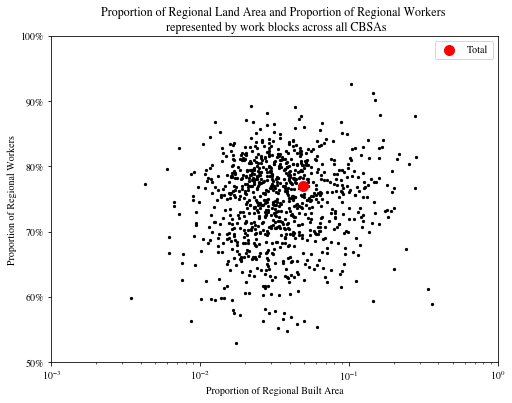

In [49]:
#Plotting
fig,ax = plt.subplots(1,1,figsize=(8,6))

x = list(msa_summary_df['Work Block Area Portion'])
y = list(msa_summary_df['Work Block Workers Portion'])

ax.scatter(x, y, s=5,color='k')
ax.scatter(total_work_block_area_portion,total_work_block_worker_portion,s=100,color='r',label = 'Total')

ax.set_title("Proportion of Regional Land Area and Proportion of Regional Workers \n represented by work blocks across all CBSAs")
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim([10**-3,1])
ax.set_ylim([.5,1])
ax.set_ylabel('Proportion of Regional Workers')
ax.set_xlabel('Proportion of Regional Built Area')

ax.yaxis.set_major_formatter(mticker.PercentFormatter(1,decimals=0))

ax.legend()
plt.show()

In [50]:
msa_clusters_dicts = []
msa_clusters_assigned_dicts = []

for eps_val in eps_vals:
    msa_clusters_dfs = []
    new_MSA_list = []
    new_msa_dfs = []

    for msa in msa_list:
        
        msa_df = work_blocks[work_blocks['CBSA']==msa]
        msa_df = msa_df.sort_values(by='Commute_Density',ascending=False)

        msa_df,msa_clusters_df = get_clusters(msa_df,eps=eps_val)

        #msa_clusters_df = msa_clusters_df[msa_clusters_df['Commuters']>50]

        if len(msa_clusters_df)>10:
            msa_clusters_dfs.append(msa_clusters_df)
            new_MSA_list.append(msa)
            new_msa_dfs.append(msa_df)

    msa_clusters_dict = dict(zip(new_MSA_list,msa_clusters_dfs))
    msa_clusters_assigned_dict = dict(zip(new_MSA_list,new_msa_dfs))
    
    msa_clusters_dicts.append(msa_clusters_dict)
    msa_clusters_assigned_dicts.append(msa_clusters_assigned_dict)

eps_clusters_dict_workblocks = dict(zip(eps_vals,msa_clusters_dicts))
eps_clusters_assigned_dict_workblocks = dict(zip(eps_vals,msa_clusters_assigned_dicts))

In [51]:
top_msas = list(msa_summary_df['MSA'])[0:50]

### Now let's look at how nation-wide business districts scale

In [52]:
#Avg cluster ranksize for workblocks
cluster_dfs_eps = []
for eps_val in eps_vals:
    
    msa_clusters_dict = eps_clusters_dict_workblocks[eps_val]
    new_MSA_list = msa_clusters_dict.keys()
    
    new_clusters_dfs = []
    for msa in new_MSA_list:
        msa_df = msa_clusters_dict[msa]
        msa_df['CBSA'] = msa
        msa_df['CBSA-Cluster'] = msa_df['CBSA'] +' - Cluster '+ str(msa_df['Cluster'])
        new_clusters_dfs.append(msa_df)

    clusters_df = pd.concat(new_clusters_dfs)
    clusters_df = clusters_df.sort_values(by='Commuters', ascending= False)
    clusters_df['Rank'] = range(1,len(clusters_df)+1)
    
    cluster_dfs_eps.append(clusters_df)
    
cluster_dfs_eps_dict_workblocks = dict(zip(eps_vals,cluster_dfs_eps))

Next: Make a plot of R^2 and alpha value for both workblocks and 50% blocks.

Let y = the number of commuters in cluster x. 

\\[ y = C x^{-a} \\]

Where C is a constant (proportional to the largest cluster in the list) and -a is a coefficient of interest.

In [53]:
def Pareto_function(x,C,a):
    return C*x**(-a)

In [54]:
#It ain't ideal, but let's ignore the numpy warnings for now since it's throwing a lot of 
    #annoying runtime/divide warnings when doing the curve fitting below
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

##### Note: This is where you would do it - toggle the rank/size cutoff to see how the resulting alpha/r^2 changes. 

In [55]:
cluster_df = cluster_dfs_eps_dict_workblocks[eps_vals[28]]
len(cluster_df)

273691

In [56]:
cluster_df = cluster_df[cluster_df['Commuters']>99]
len(cluster_df)

125620

#### Let's define an "employment" cluster as one with at least 800 workers. 

In [57]:
r_sqs = []
c_vals = [] 
a_vals = []

commuter_cutoff = 799

for eps_val in eps_vals:

    clusters_df = cluster_dfs_eps_dict_workblocks[eps_val]
    clusters_df = clusters_df[clusters_df['Commuters']>commuter_cutoff]

    x = np.array(clusters_df['Rank']) - 0.5
    y = np.array(clusters_df['Commuters'])
    
    #No, we shouldn't do this with the Pareto function - we should simply do this with the slope
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))
    
    a_val = slope
    c_val = intercept
    r_sq = r_value**2
    
    r_sqs.append(r_sq)
    c_vals.append(c_val)
    a_vals.append(a_val)
    
pareto_fit_df_workblocks = pd.DataFrame({
    'Eps_val': eps_vals,
    'alpha': a_vals,
    'constant': c_vals,
    'r_square': r_sqs})


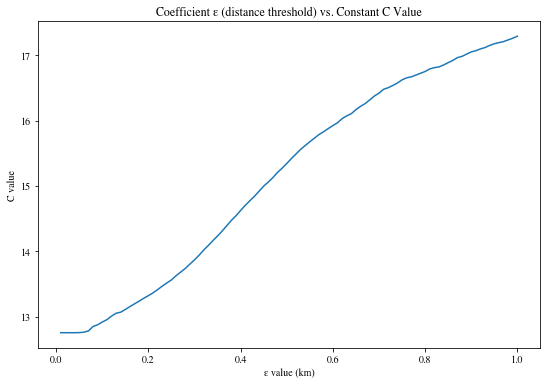

In [58]:
#Plotting
fig,ax = plt.subplots(1,1,figsize=(9,6))

ax.plot(pareto_fit_df_workblocks['Eps_val'], pareto_fit_df_workblocks['constant'])

ax.set_title("Coefficient ε (distance threshold) vs. Constant C Value")

ax.set_ylabel('C value')
ax.set_xlabel('ε value (km)')

#ax.legend()
plt.show()

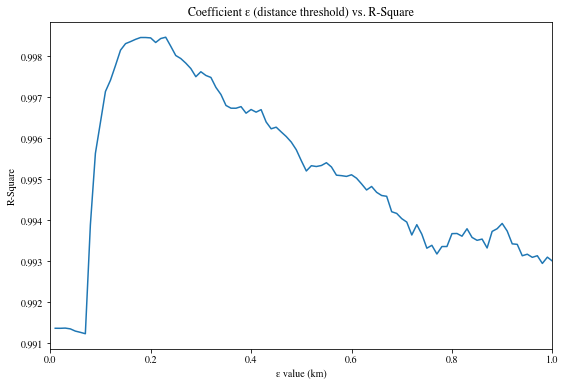

In [59]:
#Plotting
fig,ax = plt.subplots(1,1,figsize=(9,6))

ax.plot(pareto_fit_df_workblocks['Eps_val'], pareto_fit_df_workblocks['r_square'])

ax.set_title("Coefficient ε (distance threshold) vs. R-Square")

ax.set_ylabel('R-Square')
ax.set_xlabel('ε value (km)')
ax.set_xlim([0,1])

#ax.legend()
plt.show()

#### As we can see, the workblocks approach reaches a maximum R^2 with an epsilon of around 0.275 km. 

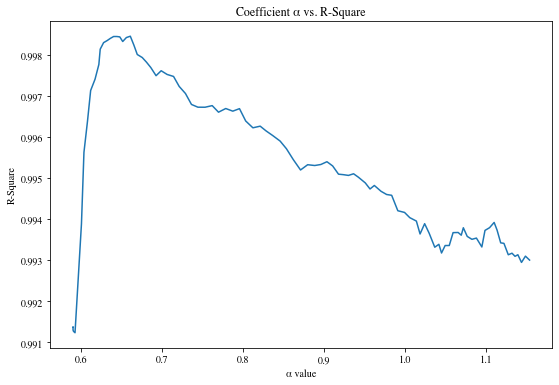

In [60]:
#Plotting
fig,ax = plt.subplots(1,1,figsize=(9,6))

ax.plot(-pareto_fit_df_workblocks['alpha'], pareto_fit_df_workblocks['r_square'])

ax.set_title("Coefficient α vs. R-Square")

ax.set_ylabel('R-Square')
ax.set_xlabel('α value')
#ax.legend()

plt.show()

#### As we can see, the optimal value of epsilon corresponds to a Pareto coefficient alpha of between 0.7 and 0.8. Unlike with the 50% threshold approach, the alpha value is strikingly consistent for varying values of alpha. 

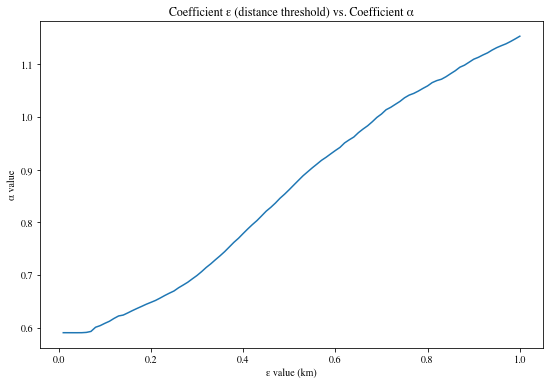

In [61]:
fig,ax = plt.subplots(1,1,figsize=(9,6))

#ax.scatter(pareto_fit_df_workblocks['Eps_val'], pareto_fit_df_workblocks['alpha'],label='Work Blocks',s=5)
ax.plot(pareto_fit_df_workblocks['Eps_val'], -pareto_fit_df_workblocks['alpha'])

ax.set_title("Coefficient ε (distance threshold) vs. Coefficient α")

ax.set_ylabel('α value')
ax.set_xlabel('ε value (km)')
#ax.legend()

plt.show()

#### Let's determine an alternative optimum Pareto coefficient, which yields an alpha closest to -1. 

In [62]:
#zipf_coef = -1
#pareto_fit_df_sort = pareto_fit_df_workblocks.iloc[(pareto_fit_df_workblocks['alpha']-zipf_coef).abs().argsort()[:1]]
#alt_opt_epsilon = pareto_fit_df_sort['Eps_val'].values[0]


##### Ok, note: This is actually not so good.....the fit is very awkward, plus the "clusters" identified are really not clusters.

#### Here again, we see that with varying values of epsilon, the corresponding value of alpha is fairly consistent for the workblocks approach. 

#### Let's view a 3-d plot of r^2, alpha, and epsilon.

Select a clustering method based on which approach yields the highest R^2? And then stick with that method for mapping. From the chosen method, isolate the top 10 blocks from the following metro areas: NYC, LA, Chicago, Boston, DC. 

In [63]:
opt_rsq = pareto_fit_df_workblocks['r_square'].max()
opt_index = pareto_fit_df_workblocks['r_square'].idxmax()
opt_epsilon = pareto_fit_df_workblocks['Eps_val'][opt_index]
opt_alpha = pareto_fit_df_workblocks['alpha'][opt_index]

print("The optimal value of epsilon is "+ str(round(opt_epsilon,3)) + " km., which yields an R-Square value of "+ str(round(opt_rsq,4)) + ' and a Pareto coefficent alpha of ' + str(round(opt_alpha,2)) +'.')


The optimal value of epsilon is 0.23 km., which yields an R-Square value of 0.9985 and a Pareto coefficent alpha of -0.66.


In [64]:
clusters_df_table = cluster_dfs_eps_dict_workblocks[opt_epsilon]

clusters_df_table = clusters_df_table[clusters_df_table['Rank']<101]

os.chdir('/Users/thomashill/Dropbox/Academic/Activities/Articles/Commuting/Fall 2021/Paper')

clusters_df_table.to_csv("Clusters.csv")

#### Note: The above chart is misleading. With increasing size of the CBSA, each cluster will represent a smaller portion of regional commuters, since there are simply more clusters. 

In [65]:
top_MSAs = list(msa_summary_df.head(100)['MSA'])

#### Let's get the clusters dataframes for just the optimal value of epsilon. Make sure the cluster cutoff threshold is 500 for all.

In [66]:
#msa_clusters_dict = eps_clusters_dict_workblocks[alt_opt_epsilon]
msa_clusters_dict = eps_clusters_dict_workblocks[opt_epsilon]

msa_list = list(msa_clusters_dict.keys())

msa_dfs = []
new_MSA_list = []
for msa in msa_list:
    msa_df = msa_clusters_dict[msa]
    msa_df = msa_df[msa_df['Commuters']>commuter_cutoff]
    msa_df = msa_df.sort_values(by='Commuters',ascending=False)
    
    #if len(msa_df)>10:
    if len(msa_df)>10:
        msa_dfs.append(msa_df)
        new_MSA_list.append(msa)
        
    #msa_dfs.append(msa_df)
    #new_MSA_list.append(msa)

msa_clusters_dict = dict(zip(new_MSA_list,msa_dfs))

In [67]:
#Here, we subset the "Clusters assigned" blocks file - necessary, so that we can appropriately extract the right shapefiles
msa_clusters_assigned_dict = eps_clusters_assigned_dict_workblocks[opt_epsilon]
#msa_clusters_assigned_dict = eps_clusters_assigned_dict_workblocks[alt_opt_epsilon]

msa_dfs = []

for msa in new_MSA_list:
    msa_clusters = msa_clusters_dict[msa]
    msa_clusters_set = list(set(msa_clusters['Cluster']))
    
    msa_blocks_df = msa_clusters_assigned_dict[msa]
    msa_blocks_df = msa_blocks_df[msa_blocks_df['Cluster'].isin(msa_clusters_set)]
    msa_blocks_df = msa_blocks_df.sort_values(by='Commuters',ascending=False)
    
    msa_dfs.append(msa_blocks_df)
    
msa_clusters_assigned_dict = dict(zip(new_MSA_list,msa_dfs))

In [68]:
clusters_df = cluster_dfs_eps_dict_workblocks[opt_epsilon]
#clusters_df = cluster_dfs_eps_dict_workblocks[alt_opt_epsilon]
clusters_df = clusters_df[clusters_df['Commuters']>commuter_cutoff]

#### Let's subset just those clusters over 1000 commuters

In [69]:
#clusters_df = clusters_df[clusters_df['Commuters']>999]
#clusters_df = clusters_df[clusters_df['Rank']<101]
#clusters_df = clusters_df[clusters_df['Rank']<1001]
#clusters_df = clusters_df[clusters_df['Rank']<10001]

In [70]:
clusters_rel_cols = ['Commuters','Area','Portion','Rank','CBSA']
clusters_df = clusters_df[clusters_rel_cols]

In [71]:
os.chdir('/Users/thomashill/Dropbox/Academic/Activities/Articles/Commuting/Fall 2021/Paper')

clusters_df.to_csv('Clusters.csv')

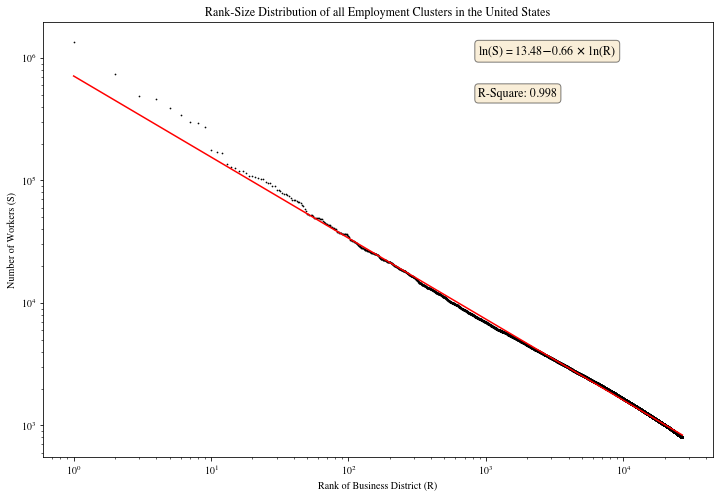

In [72]:
#Plotting
fig,ax = plt.subplots(1,1,figsize=(12,8))

x = list(clusters_df['Rank'])
y = list(clusters_df['Commuters'])

ax.scatter(x, y, s=.5,color='k')

opt_pareto_val, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))    
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))    

#Plot the OLS regression line - this will be the Pareto/rank-size relationship
ax.plot(x,np.exp(slope*np.log(x)+intercept),c= "red")

r_sq = round(r_value**2,3)

#display_text = "ln(S) = "  + str(round(intercept,2)) + " - " + str(round(-1*slope,2)) + " x ln(R)"
display_text = "ln(S) = "  + str(round(intercept,2)) + r'$ \minus $' + str(round(-1*slope,2)) + " "+ r'$ \times $' + " ln(R)"

display_text_2 = "R-Square: "+ str(r_sq)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.65, 0.95, display_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.text(0.65, 0.85, display_text_2, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

num_clusters = len(clusters_df)
plot_title = "Rank-Size Distribution of all Employment Clusters in the United States"

ax.set_title(plot_title)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim([10**4,10**(5)])
#ax.set_ylim([10**(2),10**(4)])
ax.set_ylabel('Number of Workers (S)')
ax.set_xlabel('Rank of Business District (R)')

plt.show()


#### Let's see how the top clusters scale as a portion of regional employment, with this optimal value of epsilon.

In [73]:
top_cluster_sizes = []
top_2_cluster_sizes = []
top_5_cluster_sizes = []
top_cluster_portions = []

for msa in new_MSA_list:
    msa_df = msa_clusters_dict[msa]
    
    top_cluster = msa_df.loc[msa_df['Rank']==1]['Commuters'].values[0]
    top_portion = np.sum(list(msa_df['Portion'])[0:10])
    #top_2_clusters = np.sum([msa_df.loc[msa_df['Rank']==i]['Commuters'].values[0] for i in range(1,3)])
    #top_5_clusters = np.sum([msa_df.loc[msa_df['Rank']==i]['Commuters'].values[0] for i in range(1,6)])
    
    top_cluster_sizes.append(top_cluster)
    top_cluster_portions.append(top_portion)
    #top_2_cluster_sizes.append(top_2_clusters)
    #top_5_cluster_sizes.append(top_5_clusters)
    
    
top_clusters_df = pd.DataFrame({
    'MSA': new_MSA_list,
    'Top_cluster': top_cluster_sizes,
    #'Top 2 clusters': top_2_cluster_sizes,
    #'Top 5 clusters': top_5_cluster_sizes,
    'Top_portion': top_cluster_portions})

top_clusters_df['Pop'] = top_clusters_df['MSA'].map(msa_pops_dict)

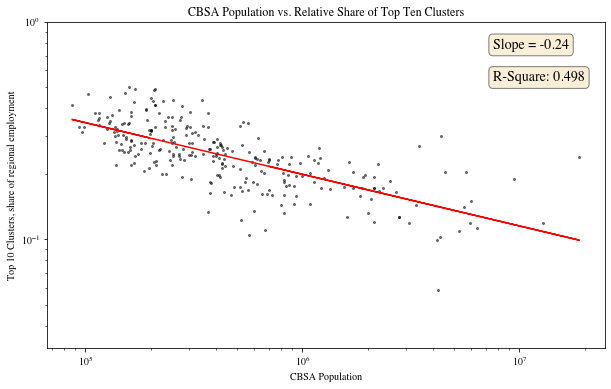

In [74]:
#Plotting
fig,ax = plt.subplots(1,1,figsize=(10,6))

x = list(top_clusters_df['Pop'])
y = list(top_clusters_df['Top_portion'])
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))    

ax.scatter(x, y,alpha=0.5,s=4,color='k')
ax.plot(x,np.exp(slope*np.log(x)+intercept),c= "red")

disp_r2_value = round(r_value**2,3)
display_text = "R-Square: "+ str(disp_r2_value)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.8, 0.85, display_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

display_text_2 = "Slope = " + str(round(slope,2))
    
ax.text(0.8, 0.95, display_text_2, transform=ax.transAxes, fontsize=14,
    verticalalignment='top', bbox=props)

ax.set_title("CBSA Population vs. Relative Share of Top Ten Clusters")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([10**(-1.5),10**(0)])

ax.set_ylabel('Top 10 Clusters, share of regional employment')
ax.set_xlabel('CBSA Population')

plt.show()

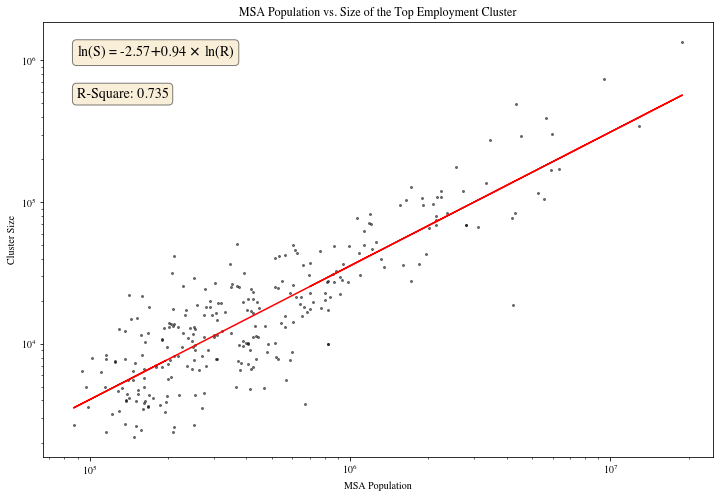

In [75]:
#Plotting
fig,ax = plt.subplots(1,1,figsize=(12,8))

x = list(top_clusters_df['Pop'])
y = list(top_clusters_df['Top_cluster'])
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))    

ax.scatter(x, y,alpha=0.5,s=4,color='k')
ax.plot(x,np.exp(slope*np.log(x)+intercept),c= "red")

disp_r2_value = round(r_value**2,3)
display_text = "R-Square: "+ str(disp_r2_value)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.85, display_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

#Show the regression formula
display_text_2 = "ln(S) = "  + str(round(intercept,2)) + r'$ \plus $' + str(round(slope,2)) + " "+ r'$ \times $' + " ln(R)"
    
ax.text(0.05, 0.95, display_text_2, transform=ax.transAxes, fontsize=14,
    verticalalignment='top', bbox=props)

ax.set_title("MSA Population vs. Size of the Top Employment Cluster")
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_ylim([10**(-1.5),10**(0)])

ax.set_ylabel('Cluster Size')
ax.set_xlabel('MSA Population')

plt.show()

#### As the above shows, there is a clear relationship between MSA population size and the proportion of employees in the top ~ten clusters. The top cluster appears to be a bit of an outlier, with a wide variance. 

#### You should show this: the variance in the proportion of workers encompassed by each cluster in the top 10. Probably the top cluster has a much higher variance that the others. 

#### Subsetting geopandas dataframes.

#### Ok, now let's fit every MSA's distribution of employment clusters to the Pareto distribution and see how the coefficients scale.

In [76]:
rsqs = []
a_vals = []
c_vals = []
nums_clusters = []

for msa in new_MSA_list:
    msa_df = msa_clusters_dict[msa]
    
    num_clusters = len(msa_df)
    
    #msa_df = msa_df[msa_df['Commuters']>100]
    
    msa_x = np.array(msa_df['Rank'])
    msa_y = np.array(msa_df['Commuters'])
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(msa_x), np.log(msa_y))    

    r_sq = r_value**2

    rsqs.append(r_sq)
    c_vals.append(intercept)
    a_vals.append(slope)
    
    nums_clusters.append(num_clusters)
    
ranksize_df = pd.DataFrame({
    "MSA": new_MSA_list,
    "Pareto coefficient": a_vals,
    "Constant value": c_vals,
    "R Square": rsqs,
    "Num Clusters": nums_clusters})

ranksize_df['Pop'] = ranksize_df['MSA'].map(msa_pops_dict)
ranksize_df['Workers'] = ranksize_df['MSA'].map(msa_workers_dict)
ranksize_df = ranksize_df.sort_values(by='Workers',ascending=False)
ranksize_df['Rank'] = range(1,len(ranksize_df)+1)

In [77]:
top_ranksize_df = ranksize_df[ranksize_df['Rank']<101]

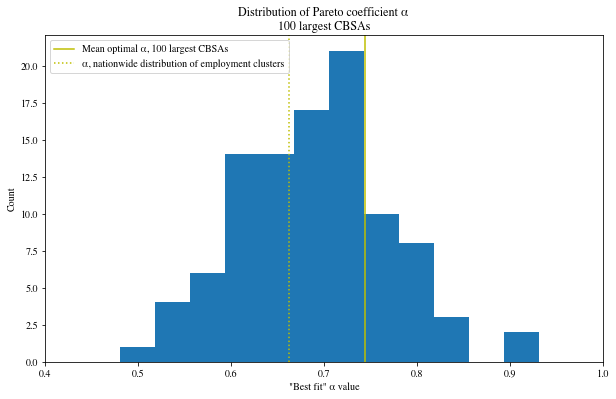

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
ax.hist(-top_ranksize_df['Pareto coefficient'],bins=12)
title = 'Distribution of Pareto coefficient α \n' + str(len(top_ranksize_df)) + ' largest CBSAs'
ax.set_title(title)
ax.set_ylabel('Count')
ax.set_xlabel('"Best fit" α value')

#ax.axvline(x=np.median(ranksize_df['Pareto coefficient']), ymin=0, ymax=80,color='y',ls=':')
ax.axvline(x=-np.mean(ranksize_df['Pareto coefficient']), ymin=0, ymax=80,color='y',ls='-',label='Mean optimal α, 100 largest CBSAs')
ax.axvline(x=-opt_pareto_val, ymin=0, ymax=80,color='y',ls=':',label='α, nationwide distribution of employment clusters')

ax.legend()
    
#ax.set_xlim([-1.25,-0.1])
ax.set_xlim([0.4,1.0])
plt.show()

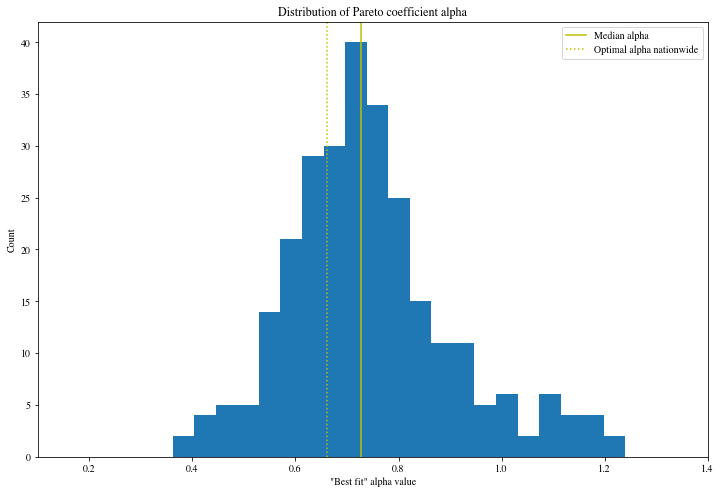

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
ax.hist(-ranksize_df['Pareto coefficient'],bins=21)
ax.set_title('Distribution of Pareto coefficient alpha')
ax.set_ylabel('Count')
ax.set_xlabel('"Best fit" alpha value')

#ax.axvline(x=np.median(-ranksize_df['Pareto coefficient']), ymin=0, ymax=80,color='y',ls=':')
ax.axvline(x=np.median(-ranksize_df['Pareto coefficient']), ymin=0, ymax=80,color='y',ls='-',label='Median alpha')
ax.axvline(x=-opt_pareto_val, ymin=0, ymax=80,color='y',ls=':',label='Optimal alpha nationwide')

ax.legend()
    
ax.set_xlim([0.1,1.4])
plt.show()

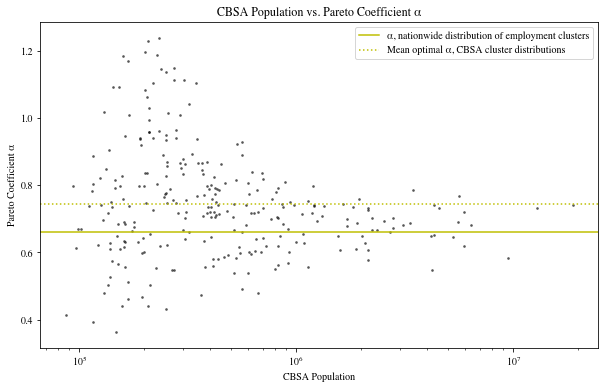

In [80]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

x = list(ranksize_df['Pop'])
y = list(-ranksize_df['Pareto coefficient'])

ax.scatter(x, y,alpha=0.5,s=3,color='k')

ax.set_title("CBSA Population vs. Pareto Coefficient α")
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_ylabel('Pareto Coefficient α')
ax.set_xlabel('CBSA Population')

ax.axhline(y=-opt_pareto_val,xmin=0, xmax=1,color='y',ls='-',label='α, nationwide distribution of employment clusters')
ax.axhline(y=np.mean(-ranksize_df['Pareto coefficient']),xmin=0, xmax=1,color='y',ls=':',label='Mean optimal α, CBSA cluster distributions')

ax.legend()

plt.show()

Clearly, there is significantly wider variation in average Pareto coefficient for smaller CBSAs. This is what we would expect: there are fewer clusters in these locations, so there is a wider variation in the scaling coefficient due to randomness. 

In [81]:
print("The average Pareto coefficient across the nation's CBSAs is " + str(round(np.mean(ranksize_df['Pareto coefficient']),3)) + ", which is very similar to the Pareto coefficient for the national distribution of employment clusters, which is "+ str(round(opt_pareto_val,3)) +".")



The average Pareto coefficient across the nation's CBSAs is -0.743, which is very similar to the Pareto coefficient for the national distribution of employment clusters, which is -0.662.


In [82]:
def plot_rank_size_with_pareto(msa): 
    
    df = msa_clusters_dict[msa]
    
    fig,ax = plt.subplots(1,1,figsize=(12,8))
    
    x = list(df['Rank'])
    y = list(df['Commuters'])
    
    ax.scatter(x,y,s=1,color='k')
    ax.set_title('Cluster rank vs. number of commuters \n' + str(msa))
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    #Plot the Pareto predicted values
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))  
    ax.plot(x,np.exp(slope*np.log(x)+intercept),c= "red")

    disp_r2_value = round(r_value**2,4)
    display_text = "R-Square: "+ str(disp_r2_value)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.7, 0.85, display_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    #Show the regression formula
    display_text_2 = "ln(S) = "  + str(round(intercept,2)) + r'$ \minus $' + str(round(-1*slope,2)) + " "+ r'$ \times $' + " ln(R)"
    
    ax.text(0.7, 0.95, display_text_2, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    ax.set_ylabel('Cluster Size (number of commuters)')
    ax.set_xlabel('Cluster Rank')

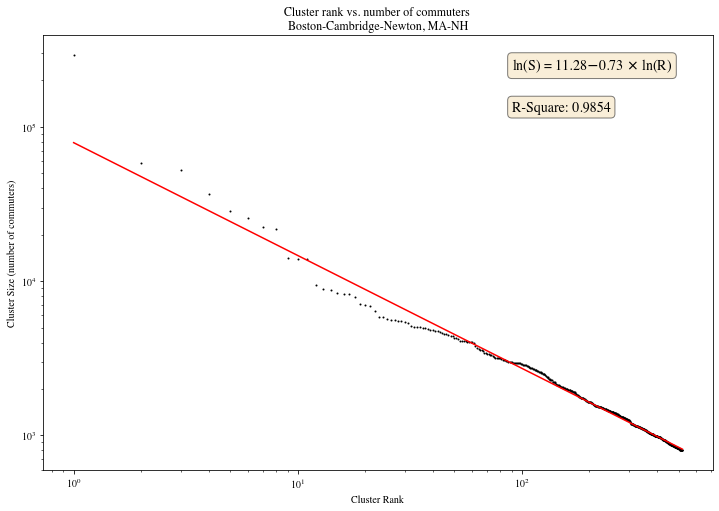

In [83]:
plot_rank_size_with_pareto(top_MSAs[7])

In [84]:
#Let's create some new msa_cluster stats. Let's see the ratio of the top cluster to the second largest, and to the 
#sum of the second and third. Let's also see what the Pareto coefficient is exluding the top ~2 clusters

ratio_top = []
ratio_top_3 = [] 
ratio_top5s = []

alphas = []
r_sqs = []

top_actuals = []
top_preds = []
top_errors = []

for msa in new_MSA_list:
    msa_df = msa_clusters_dict[msa]
    
    top_cluster = msa_df.loc[msa_df['Rank']==1]['Commuters'].values[0]
    second_cluster = msa_df.loc[msa_df['Rank']==2]['Commuters'].values[0]
    third_cluster = msa_df.loc[msa_df['Rank']==3]['Commuters'].values[0]
    fourth_cluster = msa_df.loc[msa_df['Rank']==4]['Commuters'].values[0]
    fifth_cluster = msa_df.loc[msa_df['Rank']==5]['Commuters'].values[0]
    
    ratio_1_2 = top_cluster/(second_cluster)
    ratio_1_23 = (top_cluster)/(second_cluster + third_cluster)
    ratio_top5 = (top_cluster)/(second_cluster + third_cluster + fourth_cluster + fifth_cluster)
    
    x = list(msa_df['Rank'])
    y = list(msa_df['Commuters'])
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y)) 
    
    top_est_size = np.exp(slope*np.log(1)+intercept)
    
    top_error = (top_cluster - top_est_size)/top_est_size
    
    ratio_top.append(ratio_1_2)
    ratio_top_3.append(ratio_1_23)
    alphas.append(slope)
    r_sqs.append(r_value**2)
    
    top_actuals.append(top_cluster)
    top_preds.append(top_est_size)
    top_errors.append(top_error)
    ratio_top5s.append(ratio_top5)

msa_clusters_stats = pd.DataFrame({
    'MSA': new_MSA_list,
    'Ratio_top': ratio_top,
    'Ratio_top3': ratio_top_3,
    'Ratio_top5': ratio_top5s,
    'Alpha': alphas,
    'R-Square': r_sqs,
    'Top Cluster': top_actuals,
    'Top Prediction': top_preds,
    'Top Errors': top_errors})

msa_clusters_stats['Pop'] = msa_clusters_stats['MSA'].map(msa_pops_dict)
msa_clusters_stats['Workers'] = msa_clusters_stats['MSA'].map(msa_workers_dict)
msa_clusters_stats = msa_clusters_stats.sort_values(by='Workers',ascending=False)
msa_clusters_stats['Top_portion'] = msa_clusters_stats['Top Cluster']/msa_clusters_stats['Workers']

msa_clusters_stats['X'] = msa_clusters_stats['MSA'].map(msa_x_dict)
msa_clusters_stats['Y'] = msa_clusters_stats['MSA'].map(msa_y_dict)

In [85]:
os.chdir('/Users/thomashill/Dropbox/Academic/Activities/Articles/Commuting/Fall 2021/Census Files')

msa_clusters_stats.to_csv('msa_clusters_stats.csv')

In [86]:
msa_summary_df = msa_summary_df.sort_values(by='Pop',ascending=False)
top_MSAs = list(msa_summary_df['MSA'])[0:50]

In [87]:
top_msa_clusters_stats = msa_clusters_stats[msa_clusters_stats['MSA'].isin(top_MSAs)]

In [89]:
top_msa_clusters_stats = top_msa_clusters_stats.sort_values(by='Top_portion',ascending=False)

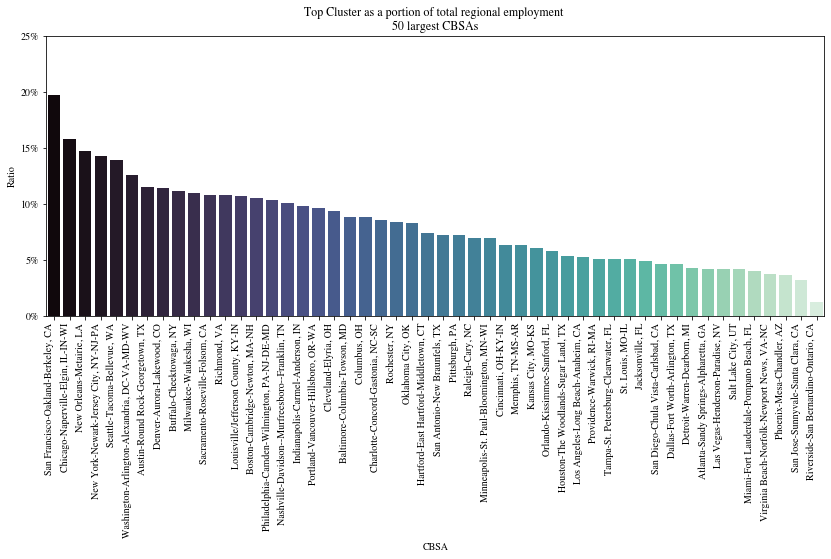

In [90]:
top_msa_clusters_stats = top_msa_clusters_stats.sort_values(by='Top_portion',ascending=False)

fig,ax = plt.subplots(figsize=(12,5))
fig.tight_layout(pad=3.0)

ax = sns.barplot(x="MSA", y="Top_portion", data=top_msa_clusters_stats, palette="mako", order=top_msa_clusters_stats["MSA"])

ax.set_title("Top Cluster as a portion of total regional employment \n" + str(len(top_msa_clusters_stats))+ ' largest CBSAs')
ax.set_ylabel('Ratio')
ax.set_xlabel('CBSA')

#ax.set_yscale('log')
ax.set_ylim([0,0.25])

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1,decimals=0))

plt.show()

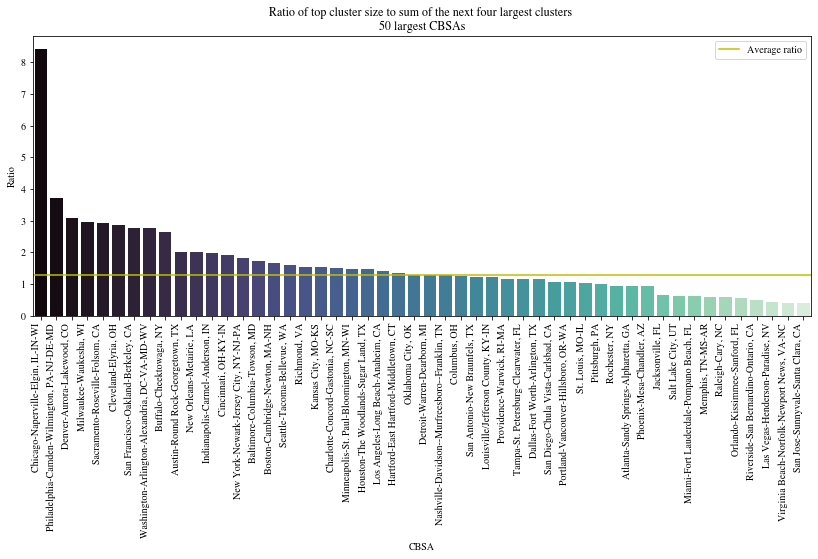

In [92]:
top_msa_clusters_stats = top_msa_clusters_stats.sort_values(by='Ratio_top5',ascending=False)

fig,ax = plt.subplots(figsize=(12,5))
fig.tight_layout(pad=3.0)

ax = sns.barplot(x="MSA", y="Ratio_top5", data=top_msa_clusters_stats, palette="mako", order=top_msa_clusters_stats["MSA"])

ax.set_title("Ratio of top cluster size to sum of the next four largest clusters \n" + str(len(top_msa_clusters_stats))+ ' largest CBSAs')
ax.set_ylabel('Ratio')
ax.set_xlabel('CBSA')

ax.axhline(y=np.median(top_msa_clusters_stats['Ratio_top5']), xmin=0, xmax=1,color='y',ls='-',label='Average ratio')
#ax.axhline(y=predicted_ratio_top5, xmin=0, xmax=1,color='y',ls='-',label='Predicted ratio')

#ax.set_yscale('log')
ax.legend()

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

plt.show()

No handles with labels found to put in legend.


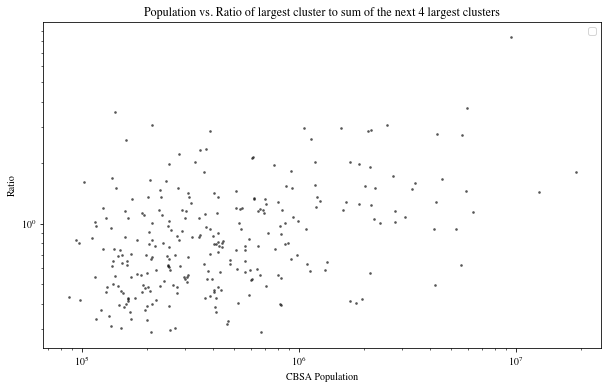

In [93]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

x = list(msa_clusters_stats['Pop'])
y = list(msa_clusters_stats['Ratio_top5'])

ax.scatter(x, y,alpha=0.5,s=3,color='k')

ax.set_title("Population vs. Ratio of largest cluster to sum of the next 4 largest clusters")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Ratio')
ax.set_xlabel('CBSA Population')

#ax.axhline(y=predicted_ratio_top5, xmin=0, xmax=1,color='y',ls='-',label='Average ratio')

ax.legend()

plt.show()

There is no obvious relationship between a CBSA's population and the ratio between its largest clusters and the next several. 

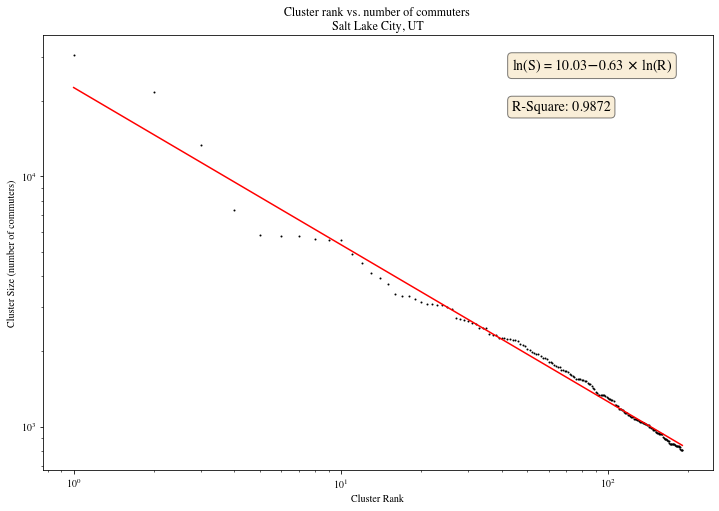

In [94]:
plot_rank_size_with_pareto('Salt Lake City, UT')

### From pure visual inspection, cities that have a reputation for being "pre-automobile" tend to have a larger central cluster, larger than what the Pareto distribution would predict. Chicago is of course an extreme outlier - but it speaks to a general pattern. 

#### New York's surprisingly low showing is because of the fact that the algorithm breaks the central business district into Midtown and the Financial District - which is appropriate. 

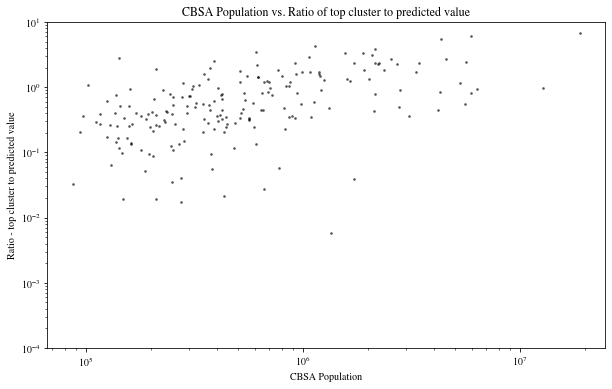

In [95]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

x = list(msa_clusters_stats['Pop'])
y = list(msa_clusters_stats['Top Errors'])

ax.scatter(x, y,alpha=0.5,s=3,color='k')

ax.set_title("CBSA Population vs. Ratio of top cluster to predicted value")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylim([0.0001,10])
ax.set_ylabel('Ratio - top cluster to predicted value')
ax.set_xlabel('CBSA Population')

plt.show()

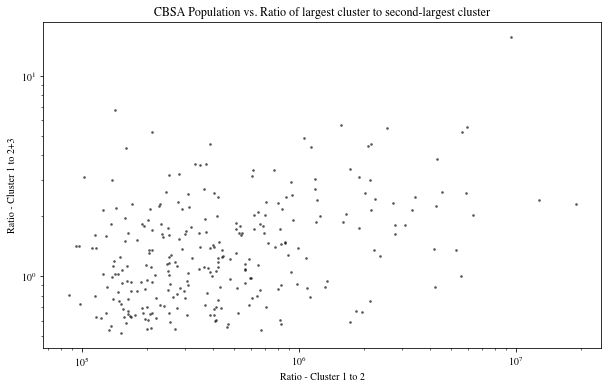

In [96]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

x = list(msa_clusters_stats['Pop'])
y = list(msa_clusters_stats['Ratio_top3'])

ax.scatter(x, y,alpha=0.5,s=3,color='k')

ax.set_title("CBSA Population vs. Ratio of largest cluster to second-largest cluster")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Ratio - Cluster 1 to 2+3')
ax.set_xlabel('Ratio - Cluster 1 to 2')

plt.show()

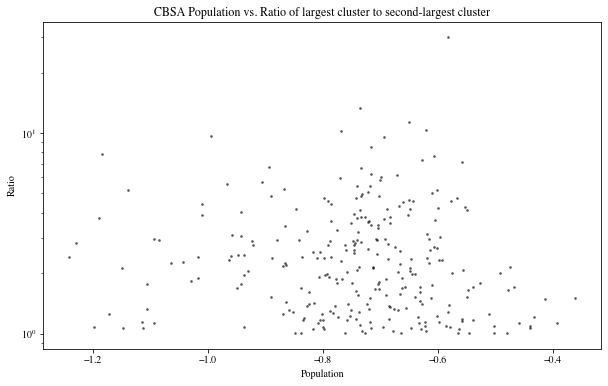

In [97]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

x = list(msa_clusters_stats['Alpha'])
y = list(msa_clusters_stats['Ratio_top'])

ax.scatter(x, y,alpha=0.5,s=3,color='k')

ax.set_title("CBSA Population vs. Ratio of largest cluster to second-largest cluster")
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Ratio')
ax.set_xlabel('Population')

plt.show()

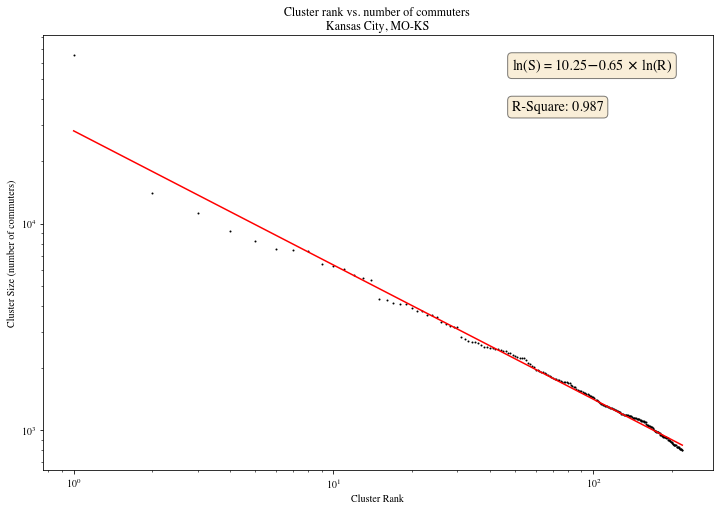

In [98]:
plot_rank_size_with_pareto(top_MSAs[29])

There is evidently no relationship between a region's population and its Pareto coefficient. That's a good thing, really: the pareto distribution is scale-invariant.

##### Note: You may want to show the actual model. What is the equation and how are the coefficients distributed? 

In [104]:
eps_vals[50]

0.51

In [105]:
msa_clusters_dict_NEW = eps_clusters_dict_workblocks[eps_vals[50]]
clusters_df_NEW = cluster_dfs_eps_dict_workblocks[eps_vals[50]]

rsqs = []
a_vals = []
c_vals = []
nums_clusters = []

for msa in new_MSA_list:
    msa_df = msa_clusters_dict_NEW[msa]
    
    num_clusters = len(msa_df)
    
    #msa_df = msa_df[msa_df['Commuters']>100]
    
    msa_x = np.array(msa_df['Rank'])
    msa_y = np.array(msa_df['Commuters'])
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(msa_x), np.log(msa_y))    

    r_sq = r_value**2

    rsqs.append(r_sq)
    c_vals.append(intercept)
    a_vals.append(slope)
    
    nums_clusters.append(num_clusters)
    
ranksize_df_NEW = pd.DataFrame({
    "MSA": new_MSA_list,
    "Pareto coefficient": a_vals,
    "Constant value": c_vals,
    "R Square": rsqs,
    "Num Clusters": nums_clusters})

ranksize_df_NEW['Pop'] = ranksize_df_NEW['MSA'].map(msa_pops_dict)
ranksize_df_NEW['Workers'] = ranksize_df_NEW['MSA'].map(msa_workers_dict)
ranksize_df_NEW = ranksize_df_NEW.sort_values(by='Workers',ascending=False)
ranksize_df_NEW['Rank'] = range(1,len(ranksize_df_NEW)+1)



In [106]:
new_ranksize_df = ranksize_df_NEW[ranksize_df_NEW['MSA'].isin(new_MSA_list)]

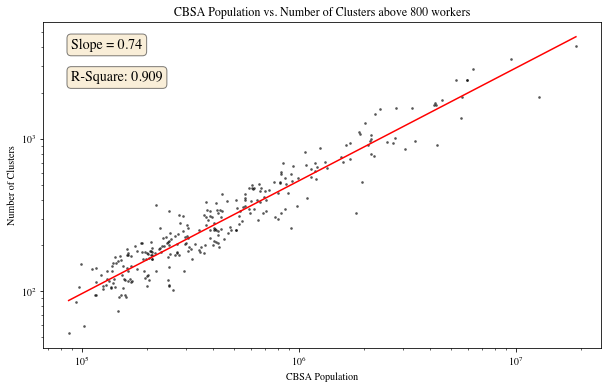

In [107]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

x = list(new_ranksize_df['Pop'])
#x = list(ranksize_df['Workers'])
y = list(new_ranksize_df['Num Clusters'])

ax.scatter(x, y,alpha=0.5,s=3,color='k')

C_slope, C_intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))    
ax.plot(x,np.exp(C_slope*np.log(x)+C_intercept),c= "red")

disp_r2_value = round(r_value**2,3)
display_text = "R-Square: "+ str(disp_r2_value)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.85, display_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

display_text_2 = "Slope = " + str(round(C_slope,2))
    
ax.text(0.05, 0.95, display_text_2, transform=ax.transAxes, fontsize=14,
    verticalalignment='top', bbox=props)

ax.set_title("CBSA Population vs. Number of Clusters above 800 workers")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Number of Clusters')
ax.set_xlabel('CBSA Population')

#ax.set_ylim([6*10**0,2*10**1])

plt.show()

The number of clusters above a certain size scales in direct proportion to a region's employed population. What's striking is that this is also a power law. 

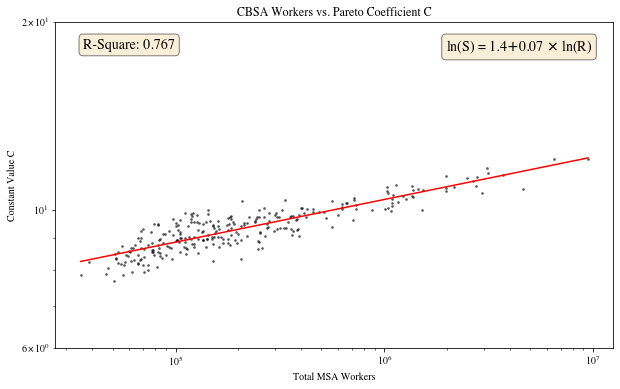

In [101]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

#x = list(ranksize_df['Pop'])
x = list(ranksize_df['Workers'])
y = list(ranksize_df['Constant value'])

ax.scatter(x, y,alpha=0.5,s=3,color='k')

C_slope, C_intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))    
ax.plot(x,np.exp(C_slope*np.log(x)+C_intercept),c= "red")

disp_r2_value = round(r_value**2,3)
display_text = "R-Square: "+ str(disp_r2_value)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, display_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

display_text_2 = "ln(S) = "  + str(round(C_intercept,2)) + r'$ \plus $' + str(round(C_slope,2)) + " "+ r'$ \times $' + " ln(R)"
    
ax.text(0.7, 0.95, display_text_2, transform=ax.transAxes, fontsize=14,
    verticalalignment='top', bbox=props)

ax.set_title("CBSA Workers vs. Pareto Coefficient C")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Constant Value C')
ax.set_xlabel('Total MSA Workers')

ax.set_ylim([6*10**0,2*10**1])

plt.show()

Ok, let's write a formula to calculate the Pareto constant C based on an MSA's population. 

In [ ]:
x = list(ranksize_df['Workers'])
y = list(ranksize_df['Constant value'])

C_slope, C_intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y)) 

In [ ]:
def calculate_C_val(msa_workers):
    
    C_val = np.exp(C_slope*np.log(msa_workers)+C_intercept)
    
    return C_val
    

In [ ]:
ranksize_df['Calculate_C'] = [calculate_C_val(workers) for workers in list(ranksize_df['Workers'])]

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

#x = list(ranksize_df['Pop'])
x = list(ranksize_df['Workers'])
y = list(ranksize_df['Constant value'])
z = list(ranksize_df['Calculate_C'])

ax.scatter(x, y,alpha=0.5,s=3,color='k')

C_slope, C_intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))    
#ax.plot(x,np.exp(C_slope*np.log(x)+C_intercept),c= "red")

ax.plot(x,z,c='y')

ax.set_title("MSA Workers vs. Pareto Coefficient C")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Constant Value C')
ax.set_xlabel('Total MSA Workers')

ax.set_ylim([6*10**0,2*10**1])

plt.show()

In [ ]:
C_dict = dict(zip(ranksize_df['MSA'],ranksize_df['Calculate_C']))
num_clusters_dict = dict(zip(ranksize_df['MSA'],ranksize_df['Num Clusters']))

In [ ]:
opt_pareto_val

In [ ]:
#opt_pareto_val = -0.6772892461818465
#true_opt_pareto_val = -0.6772892461818465

In [ ]:
def calculate_cluster_distribution(msa):
    C_val = C_dict[msa]
    num_clusters = num_clusters_dict[msa]
    
    cluster_range = list(range(1,num_clusters+1))
    
    cluster_sizes = []
    
    for cluster in cluster_range:
        cluster_size = np.exp(opt_pareto_val*np.log(cluster)+C_val)
        cluster_sizes.append(cluster_size)
    
    msa_clusters_df = msa_clusters_dict[msa]
    msa_clusters_df = msa_clusters_df.sort_values(by='Commuters',ascending=False)
    msa_clusters_df['Predicted Cluster Size'] = cluster_sizes
    
    return msa_clusters_df

In [ ]:
r_sq_vals = []
msa_clusters_dfs = []

for msa in new_MSA_list:
    msa_clusters_df = calculate_cluster_distribution(msa)
    
    predicted_vals = msa_clusters_df['Predicted Cluster Size']
    actual_vals = msa_clusters_df['Commuters']
    
    r_sq = r2_score(actual_vals,predicted_vals)
    
    r_sq_vals.append(r_sq)
    
    msa_clusters_dfs.append(msa_clusters_df)
    

msa_clusters_dict = dict(zip(new_MSA_list,msa_clusters_dfs))
r_sq_dict = dict(zip(new_MSA_list,r_sq_vals))
ranksize_df['Predicted R Square'] = ranksize_df['MSA'].map(r_sq_dict)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

#x = list(ranksize_df['Pop'])
x = list(ranksize_df['Workers'])
y = list(ranksize_df['Predicted R Square'])
#z = list(ranksize_df['Calculate_C'])

ax.scatter(x, y,alpha=0.5,s=3,color='k')

#C_slope, C_intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))    
#ax.plot(x,np.exp(C_slope*np.log(x)+C_intercept),c= "red")

#ax.plot(x,z,c='y')

ax.set_title("MSA Workers vs. R Squared of Overall Model")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('R Squared')
ax.set_xlabel('Total MSA Workers')

#ax.set_ylim([6*10**0,2*10**1])

plt.show()

In [ ]:
def plot_rank_size_with_preds(msa): 
    
    df = msa_clusters_dict[msa]
    
    fig,ax = plt.subplots(1,1,figsize=(12,8))
    
    x = list(df['Rank'])
    y = list(df['Commuters'])
    
    ax.scatter(x,y,s=1,color='k')
    ax.set_title('Cluster rank vs. number of commuters \n' + str(msa))
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    #Plot the Pareto predicted values
    #slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y)) 
    
    C_val = C_dict[msa]
    
    predicted_vals = np.exp(opt_pareto_val*np.log(x)+C_val)
    ax.plot(x,predicted_vals,c= "red")
    
    r_sq = r2_score(y,predicted_vals)
    
    disp_r2_value = round(r_sq,4)
    display_text = "R-Square: "+ str(disp_r2_value)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.7, 0.85, display_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    #Show the regression formula
    display_text_2 = "ln(S) = "  + str(round(C_val,2)) + r'$ \minus $' + str(round(-1*opt_pareto_val,2)) + " "+ r'$ \times $' + " ln(R)"
    
    ax.text(0.7, 0.95, display_text_2, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    ax.set_ylabel('Cluster Size (number of commuters)')
    ax.set_xlabel('Cluster Rank')

In [ ]:
plot_rank_size_with_preds('Salt Lake City, UT')

In [ ]:
plot_rank_size_with_preds(top_MSAs[3])

In [ ]:
plot_rank_size_with_preds('Providence-Warwick, RI-MA')

In [ ]:
top_ranksize_df = ranksize_df[ranksize_df['MSA'].isin(top_MSAs)]

In [ ]:
top_ranksize_df = top_ranksize_df[top_ranksize_df['Predicted R Square']>0]
top_ranksize_df = top_ranksize_df.sort_values(by='Predicted R Square',ascending=False)

fig,ax = plt.subplots(figsize=(12,5))
fig.tight_layout(pad=3.0)

ax = sns.barplot(x="MSA", y="Predicted R Square", data=top_ranksize_df, palette="mako", order=top_ranksize_df["MSA"])

ax.set_title("R-Square of Power Law with α = 2/3 for 50 largest CBSAs")
ax.set_ylabel('R-Square')
#ax.set_xlabel('CBSA')

#ax.axhline(y=np.median(top_msa_clusters_stats['Ratio_top5']), xmin=0, xmax=1,color='y',ls='-',label='Average ratio')
ax.axhline(y=np.median(top_ranksize_df['Predicted R Square']), xmin=0, xmax=1,color='y',ls='-',label='Median R-Square')

#ax.set_yscale('log')
ax.legend()

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1,decimals=0))

ax.set_ylim([0.2,1])

plt.show()

In [ ]:
top_rank_MSAs = list(top_ranksize_df['MSA'])

In [ ]:
plot_ranksize_df = ranksize_df[ranksize_df['Predicted R Square']>0]
med_rsq = np.median(ranksize_df['Predicted R Square'])

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
ax.hist(plot_ranksize_df['Predicted R Square'],bins=15)
ax.set_title('R Square distribution')
ax.set_ylabel('Count')
ax.set_xlabel('R Square')

ax.axvline(x=med_rsq,ymin=0,ymax=70,color='y',ls=':',label='Median R Square')
    
ax.set_xlim([0,1])
ax.legend()
plt.show()


In [ ]:
plot_rank_size_with_preds('Washington-Arlington-Alexandria, DC-VA-MD-WV')

In [ ]:
plot_rank_size_with_pareto('Chicago-Naperville-Elgin, IL-IN-WI')

In [ ]:
plot_rank_size_with_pareto('Atlanta-Sandy Springs-Alpharetta, GA')

In [ ]:
plot_rank_size_with_pareto('Los Angeles-Long Beach-Anaheim, CA')

In [ ]:
plot_rank_size_with_pareto('Washington-Arlington-Alexandria, DC-VA-MD-WV')

In [ ]:
plot_rank_size_with_pareto('Houston-The Woodlands-Sugar Land, TX')

In [ ]:
plot_rank_size_with_pareto('Boston-Cambridge-Newton, MA-NH')

In [ ]:
plot_rank_size_with_pareto('New York-Newark-Jersey City, NY-NJ-PA')

#### Now, let's calculate the distance between clusters.

##### Note: We should delete the below cell before re-running, since the above code has since been corrected

In [1301]:
msa_clusters_dfs = []
new_MSA_list = []
new_msa_dfs = []

for msa in msa_list:
        
    msa_df = work_blocks[work_blocks['CBSA']==msa]
    msa_df = msa_df.sort_values(by='Commute_Density',ascending=False)

    msa_df,msa_clusters_df = get_clusters(msa_df,eps=opt_epsilon)

    #msa_clusters_df = msa_clusters_df[msa_clusters_df['Commuters']>50]

    if len(msa_clusters_df)>10:
        msa_clusters_dfs.append(msa_clusters_df)
        new_MSA_list.append(msa)
        new_msa_dfs.append(msa_df)

msa_clusters_dict = dict(zip(new_MSA_list,msa_clusters_dfs))
msa_clusters_assigned_dict = dict(zip(new_MSA_list,new_msa_dfs))

In [1302]:
dists_1_2 = []
dists_1_3 = []

for msa in new_MSA_list:
    msa_clusters_df = msa_clusters_dict[msa]
    msa_clusters_df['Coords'] = list(msa_clusters_df[['Y_Center', 'X_Center']].values)
    
    cluster_1_coords = list(msa_clusters_df['Coords'])[0]
    cluster_2_coords = list(msa_clusters_df['Coords'])[1]
    cluster_3_coords = list(msa_clusters_df['Coords'])[2]
    
    dist_1_2 = geopy.distance.vincenty(cluster_1_coords, cluster_2_coords).km
    dist_1_3 = geopy.distance.vincenty(cluster_1_coords, cluster_3_coords).km
    
    dists_1_2.append(dist_1_2)
    dists_1_3.append(dist_1_3)
    
dists_1_2_dict = dict(zip(new_MSA_list,dists_1_2))
dists_1_3_dict = dict(zip(new_MSA_list,dists_1_3))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  del sys.path[0]


In [1303]:
ranksize_df['Dist_1_2'] = ranksize_df['MSA'].map(dists_1_2_dict)
ranksize_df['Dist_1_3'] = ranksize_df['MSA'].map(dists_1_3_dict)

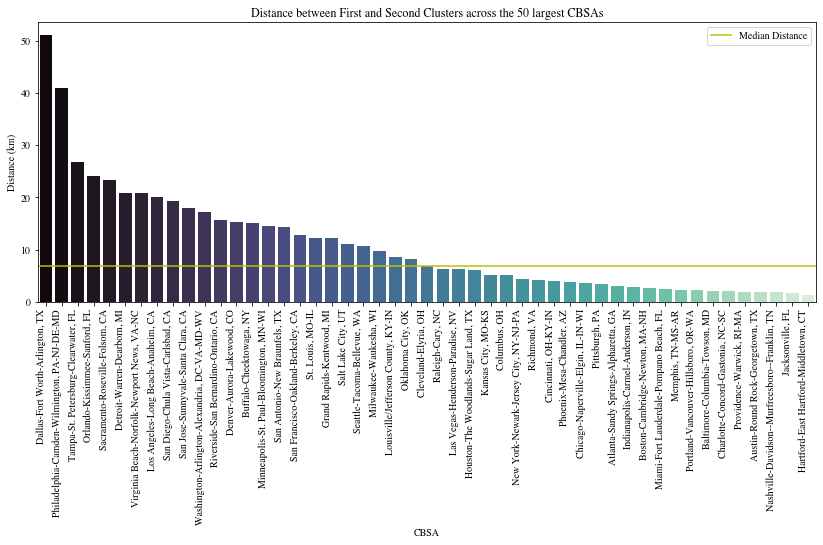

In [1307]:
top_ranksize_df = ranksize_df[ranksize_df['Rank']<50]
top_ranksize_df = top_ranksize_df.sort_values(by='Dist_1_2',ascending=False)

fig,ax = plt.subplots(figsize=(12,5))
fig.tight_layout(pad=3.0)

ax = sns.barplot(x="MSA", y="Dist_1_2", data=top_ranksize_df, palette="mako", order=top_ranksize_df["MSA"])

ax.set_title("Distance between First and Second Clusters across the " + str(len(top_msa_clusters_stats))+ ' largest CBSAs')
ax.set_ylabel('Distance (km)')
ax.set_xlabel('CBSA')

#ax.axhline(y=np.median(top_msa_clusters_stats['Ratio_top5']), xmin=0, xmax=1,color='y',ls='-',label='Average ratio')
ax.axhline(y=np.median(top_ranksize_df['Dist_1_2']), xmin=0, xmax=1,color='y',ls='-',label='Median Distance')

#ax.set_yscale('log')
ax.legend()

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
#ax.yaxis.set_major_formatter(mticker.PercentFormatter(1,decimals=0))


plt.show()

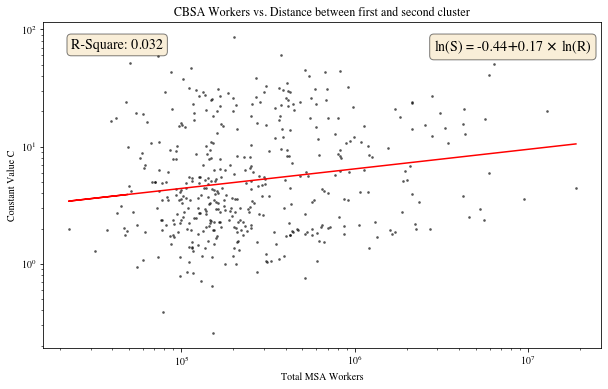

In [1308]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

#x = list(ranksize_df['Pop'])
x = list(ranksize_df['Pop'])
y = list(ranksize_df['Dist_1_2'])

ax.scatter(x, y,alpha=0.5,s=3,color='k')

C_slope, C_intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(y))    
ax.plot(x,np.exp(C_slope*np.log(x)+C_intercept),c= "red")

disp_r2_value = round(r_value**2,3)
display_text = "R-Square: "+ str(disp_r2_value)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, display_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

display_text_2 = "ln(S) = "  + str(round(C_intercept,2)) + r'$ \plus $' + str(round(C_slope,2)) + " "+ r'$ \times $' + " ln(R)"
    
ax.text(0.7, 0.95, display_text_2, transform=ax.transAxes, fontsize=14,
    verticalalignment='top', bbox=props)

ax.set_title("CBSA Workers vs. Distance between first and second cluster")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Constant Value C')
ax.set_xlabel('Total MSA Workers')

#ax.set_ylim([6*10**0,2*10**1])

plt.show()

### OK, the below is just subsetting the clusters in each of a subset of cities

In [964]:
def get_top_clusters_df(msa,n=10):
    msa_df = msa_clusters_dict[msa]
    
    #Let's exclude blocks with suspiciously high population densities
    msa_df = msa_df[msa_df['Commuter_density']<400000]
    msa_df = msa_df[msa_df['Area']>0.2]
    
    msa_top_clusters_list = list(msa_df['Cluster'])[0:n]
    
    msa_df = msa_clusters_assigned_dict[msa]
    msa_top_clusters_df = msa_df[msa_df['Cluster'].isin(msa_top_clusters_list)]
    
    return msa_top_clusters_df

In [965]:
ny_top_clusters_df = get_top_clusters_df('New York-Newark-Jersey City, NY-NJ-PA')
la_top_clusters_df = get_top_clusters_df('Los Angeles-Long Beach-Anaheim, CA')
dc_top_clusters_df = get_top_clusters_df('Washington-Arlington-Alexandria, DC-VA-MD-WV')

ny_top_clusters_blocks = list(ny_top_clusters_df['BLOCKID10'])
la_top_clusters_blocks = list(la_top_clusters_df['BLOCKID10'])
dc_top_clusters_blocks = list(dc_top_clusters_df['BLOCKID10'])

In [966]:
chicago_top_clusters_df = get_top_clusters_df('Chicago-Naperville-Elgin, IL-IN-WI')
sf_top_clusters_df = get_top_clusters_df('San Francisco-Oakland-Berkeley, CA')
boston_top_clusters_df = get_top_clusters_df('Boston-Cambridge-Newton, MA-NH')

chicago_top_clusters_blocks = list(chicago_top_clusters_df['BLOCKID10'])
sf_top_clusters_blocks = list(sf_top_clusters_df['BLOCKID10'])
boston_top_clusters_blocks = list(boston_top_clusters_df['BLOCKID10'])

In [967]:
houston_top_clusters_df = get_top_clusters_df('Houston-The Woodlands-Sugar Land, TX')
atlanta_top_clusters_df = get_top_clusters_df('Atlanta-Sandy Springs-Alpharetta, GA')
phoenix_top_clusters_df = get_top_clusters_df('Phoenix-Mesa-Chandler, AZ')

houston_top_clusters_blocks = list(houston_top_clusters_df['BLOCKID10'])
atlanta_top_clusters_blocks = list(atlanta_top_clusters_df['BLOCKID10'])
phoenix_top_clusters_blocks = list(phoenix_top_clusters_df['BLOCKID10'])

In [968]:
houston_clusters_dict = dict(zip(houston_top_clusters_df['BLOCKID10'],houston_top_clusters_df['Cluster']))
houston_commuters_dict = dict(zip(houston_top_clusters_df['BLOCKID10'],houston_top_clusters_df['Commuters']))
houston_areas_dict = dict(zip(houston_top_clusters_df['BLOCKID10'],houston_top_clusters_df['Area_km']))

atlanta_clusters_dict = dict(zip(atlanta_top_clusters_df['BLOCKID10'],atlanta_top_clusters_df['Cluster']))
atlanta_commuters_dict = dict(zip(atlanta_top_clusters_df['BLOCKID10'],atlanta_top_clusters_df['Commuters']))
atlanta_areas_dict = dict(zip(atlanta_top_clusters_df['BLOCKID10'],atlanta_top_clusters_df['Area_km']))

phoenix_clusters_dict = dict(zip(phoenix_top_clusters_df['BLOCKID10'],phoenix_top_clusters_df['Cluster']))
phoenix_commuters_dict = dict(zip(phoenix_top_clusters_df['BLOCKID10'],phoenix_top_clusters_df['Commuters']))
phoenix_areas_dict = dict(zip(phoenix_top_clusters_df['BLOCKID10'],phoenix_top_clusters_df['Area_km']))


In [969]:
boston_clusters_dict = dict(zip(boston_top_clusters_df['BLOCKID10'],boston_top_clusters_df['Cluster']))
boston_commuters_dict = dict(zip(boston_top_clusters_df['BLOCKID10'],boston_top_clusters_df['Commuters']))
boston_areas_dict = dict(zip(boston_top_clusters_df['BLOCKID10'],boston_top_clusters_df['Area_km']))

chicago_clusters_dict = dict(zip(chicago_top_clusters_df['BLOCKID10'],chicago_top_clusters_df['Cluster']))
chicago_commuters_dict = dict(zip(chicago_top_clusters_df['BLOCKID10'],chicago_top_clusters_df['Commuters']))
chicago_areas_dict = dict(zip(chicago_top_clusters_df['BLOCKID10'],chicago_top_clusters_df['Area_km']))

sf_clusters_dict = dict(zip(sf_top_clusters_df['BLOCKID10'],sf_top_clusters_df['Cluster']))
sf_commuters_dict = dict(zip(sf_top_clusters_df['BLOCKID10'],sf_top_clusters_df['Commuters']))
sf_areas_dict = dict(zip(sf_top_clusters_df['BLOCKID10'],sf_top_clusters_df['Area_km']))


In [970]:
ny_clusters_dict = dict(zip(ny_top_clusters_df['BLOCKID10'],ny_top_clusters_df['Cluster']))
ny_commuters_dict = dict(zip(ny_top_clusters_df['BLOCKID10'],ny_top_clusters_df['Commuters']))
ny_areas_dict = dict(zip(ny_top_clusters_df['BLOCKID10'],ny_top_clusters_df['Area_km']))

la_clusters_dict = dict(zip(la_top_clusters_df['BLOCKID10'],la_top_clusters_df['Cluster']))
la_commuters_dict = dict(zip(la_top_clusters_df['BLOCKID10'],la_top_clusters_df['Commuters']))
la_areas_dict = dict(zip(la_top_clusters_df['BLOCKID10'],la_top_clusters_df['Area_km']))

dc_clusters_dict = dict(zip(dc_top_clusters_df['BLOCKID10'],dc_top_clusters_df['Cluster']))
dc_commuters_dict = dict(zip(dc_top_clusters_df['BLOCKID10'],dc_top_clusters_df['Commuters']))
dc_areas_dict = dict(zip(dc_top_clusters_df['BLOCKID10'],dc_top_clusters_df['Area_km']))

Ok, let's read in the work blocks shapefiles for just these three metro areas, and then extract the top 10 clusters from each. 

In [971]:
path = '/Users/thomashill/Dropbox/Academic/Activities/Articles/Commuting/Fall 2021/Census Files/MSA_Shapefiles/NY_work'
os.chdir(path)
file_names = os.listdir()
shapefile = [s for s in file_names if s[-4:]=='.shp'][0]
ny_work_shapefile = gpd.read_file(shapefile)
#ny_work_shapefile = ny_work_shapefile.to_crs(epsg=3857)

path = '/Users/thomashill/Dropbox/Academic/Activities/Articles/Commuting/Fall 2021/Census Files/MSA_Shapefiles/LA_work'
os.chdir(path)
file_names = os.listdir()
shapefile = [s for s in file_names if s[-4:]=='.shp'][0]
la_work_shapefile = gpd.read_file(shapefile)
#la_work_shapefile = la_work_shapefile.to_crs(epsg=3857)

path = '/Users/thomashill/Dropbox/Academic/Activities/Articles/Commuting/Fall 2021/Census Files/MSA_Shapefiles/DC_work'
os.chdir(path)
file_names = os.listdir()
shapefile = [s for s in file_names if s[-4:]=='.shp'][0]
dc_work_shapefile = gpd.read_file(shapefile)
#dc_work_shapefile = dc_work_shapefile.to_crs(epsg=3857)

ny_top10_clusters_shape = ny_work_shapefile[ny_work_shapefile['BLOCKID10'].isin(ny_top_clusters_blocks)]
la_top10_clusters_shape = la_work_shapefile[la_work_shapefile['BLOCKID10'].isin(la_top_clusters_blocks)]
dc_top10_clusters_shape = dc_work_shapefile[dc_work_shapefile['BLOCKID10'].isin(dc_top_clusters_blocks)]

In [972]:
path = '/Users/thomashill/Dropbox/Academic/Activities/Articles/Commuting/Fall 2021/Census Files/MSA_Shapefiles/SF_work'
os.chdir(path)
file_names = os.listdir()
shapefile = [s for s in file_names if s[-4:]=='.shp'][0]
sf_work_shapefile = gpd.read_file(shapefile)
#ny_work_shapefile = ny_work_shapefile.to_crs(epsg=3857)

path = '/Users/thomashill/Dropbox/Academic/Activities/Articles/Commuting/Fall 2021/Census Files/MSA_Shapefiles/Chicago_work'
os.chdir(path)
file_names = os.listdir()
shapefile = [s for s in file_names if s[-4:]=='.shp'][0]
chicago_work_shapefile = gpd.read_file(shapefile)
#la_work_shapefile = la_work_shapefile.to_crs(epsg=3857)

path = '/Users/thomashill/Dropbox/Academic/Activities/Articles/Commuting/Fall 2021/Census Files/MSA_Shapefiles/Boston_work'
os.chdir(path)
file_names = os.listdir()
shapefile = [s for s in file_names if s[-4:]=='.shp'][0]
boston_work_shapefile = gpd.read_file(shapefile)
#dc_work_shapefile = dc_work_shapefile.to_crs(epsg=3857)

sf_top10_clusters_shape = sf_work_shapefile[sf_work_shapefile['BLOCKID10'].isin(sf_top_clusters_blocks)]
chicago_top10_clusters_shape = chicago_work_shapefile[chicago_work_shapefile['BLOCKID10'].isin(chicago_top_clusters_blocks)]
boston_top10_clusters_shape = boston_work_shapefile[boston_work_shapefile['BLOCKID10'].isin(boston_top_clusters_blocks)]

In [973]:
path = '/Users/thomashill/Dropbox/Academic/Activities/Articles/Commuting/Fall 2021/Census Files/MSA_Shapefiles/Houston_work'
os.chdir(path)
file_names = os.listdir()
shapefile = [s for s in file_names if s[-4:]=='.shp'][0]
houston_work_shapefile = gpd.read_file(shapefile)
#ny_work_shapefile = ny_work_shapefile.to_crs(epsg=3857)

path = '/Users/thomashill/Dropbox/Academic/Activities/Articles/Commuting/Fall 2021/Census Files/MSA_Shapefiles/Atlanta_work'
os.chdir(path)
file_names = os.listdir()
shapefile = [s for s in file_names if s[-4:]=='.shp'][0]
atlanta_work_shapefile = gpd.read_file(shapefile)
#la_work_shapefile = la_work_shapefile.to_crs(epsg=3857)

path = '/Users/thomashill/Dropbox/Academic/Activities/Articles/Commuting/Fall 2021/Census Files/MSA_Shapefiles/Phoenix_work'
os.chdir(path)
file_names = os.listdir()
shapefile = [s for s in file_names if s[-4:]=='.shp'][0]
phoenix_work_shapefile = gpd.read_file(shapefile)
#dc_work_shapefile = dc_work_shapefile.to_crs(epsg=3857)

houston_top10_clusters_shape = houston_work_shapefile[houston_work_shapefile['BLOCKID10'].isin(houston_top_clusters_blocks)]
atlanta_top10_clusters_shape = atlanta_work_shapefile[atlanta_work_shapefile['BLOCKID10'].isin(atlanta_top_clusters_blocks)]
phoenix_top10_clusters_shape = phoenix_work_shapefile[phoenix_work_shapefile['BLOCKID10'].isin(phoenix_top_clusters_blocks)]

Ok, before saving the files, let's assign to each block in the shapefile the number of commuters + the assigned cluster.

In [974]:
houston_top10_clusters_shape['Cluster'] = houston_top10_clusters_shape['BLOCKID10'].map(houston_clusters_dict)
houston_top10_clusters_shape['Commuters'] = houston_top10_clusters_shape['BLOCKID10'].map(houston_commuters_dict)
houston_top10_clusters_shape['Area_km'] = houston_top10_clusters_shape['BLOCKID10'].map(houston_areas_dict)

atlanta_top10_clusters_shape['Cluster'] = atlanta_top10_clusters_shape['BLOCKID10'].map(atlanta_clusters_dict)
atlanta_top10_clusters_shape['Commuters'] = atlanta_top10_clusters_shape['BLOCKID10'].map(atlanta_commuters_dict)
atlanta_top10_clusters_shape['Area_km'] = atlanta_top10_clusters_shape['BLOCKID10'].map(atlanta_areas_dict)

phoenix_top10_clusters_shape['Cluster'] = phoenix_top10_clusters_shape['BLOCKID10'].map(phoenix_clusters_dict)
phoenix_top10_clusters_shape['Commuters'] = phoenix_top10_clusters_shape['BLOCKID10'].map(phoenix_commuters_dict)
phoenix_top10_clusters_shape['Area_km'] = phoenix_top10_clusters_shape['BLOCKID10'].map(phoenix_areas_dict)

boston_top10_clusters_shape['Cluster'] = boston_top10_clusters_shape['BLOCKID10'].map(boston_clusters_dict)
boston_top10_clusters_shape['Commuters'] = boston_top10_clusters_shape['BLOCKID10'].map(boston_commuters_dict)
boston_top10_clusters_shape['Area_km'] = boston_top10_clusters_shape['BLOCKID10'].map(boston_areas_dict)

sf_top10_clusters_shape['Cluster'] = sf_top10_clusters_shape['BLOCKID10'].map(sf_clusters_dict)
sf_top10_clusters_shape['Commuters'] = sf_top10_clusters_shape['BLOCKID10'].map(sf_commuters_dict)
sf_top10_clusters_shape['Area_km'] = sf_top10_clusters_shape['BLOCKID10'].map(sf_areas_dict)

chicago_top10_clusters_shape['Cluster'] = chicago_top10_clusters_shape['BLOCKID10'].map(chicago_clusters_dict)
chicago_top10_clusters_shape['Commuters'] = chicago_top10_clusters_shape['BLOCKID10'].map(chicago_commuters_dict)
chicago_top10_clusters_shape['Area_km'] = chicago_top10_clusters_shape['BLOCKID10'].map(chicago_areas_dict)



In [975]:
ny_top10_clusters_shape['Cluster'] = ny_top10_clusters_shape['BLOCKID10'].map(ny_clusters_dict)
ny_top10_clusters_shape['Commuters'] = ny_top10_clusters_shape['BLOCKID10'].map(ny_commuters_dict)
ny_top10_clusters_shape['Area_km'] = ny_top10_clusters_shape['BLOCKID10'].map(ny_areas_dict)

dc_top10_clusters_shape['Cluster'] = dc_top10_clusters_shape['BLOCKID10'].map(dc_clusters_dict)
dc_top10_clusters_shape['Commuters'] = dc_top10_clusters_shape['BLOCKID10'].map(dc_commuters_dict)
dc_top10_clusters_shape['Area_km'] = dc_top10_clusters_shape['BLOCKID10'].map(dc_areas_dict)

la_top10_clusters_shape['Cluster'] = la_top10_clusters_shape['BLOCKID10'].map(la_clusters_dict)
la_top10_clusters_shape['Commuters'] = la_top10_clusters_shape['BLOCKID10'].map(la_commuters_dict)
la_top10_clusters_shape['Area_km'] = la_top10_clusters_shape['BLOCKID10'].map(la_areas_dict)


In [976]:
houston_top10_clusters_dissolved = houston_top10_clusters_shape.dissolve(by='Cluster',aggfunc='sum')
atlanta_top10_clusters_dissolved = atlanta_top10_clusters_shape.dissolve(by='Cluster',aggfunc='sum')
phoenix_top10_clusters_dissolved = phoenix_top10_clusters_shape.dissolve(by='Cluster',aggfunc='sum')

houston_top10_clusters_dissolved['Commuter_Density'] = houston_top10_clusters_dissolved['Commuters']/houston_top10_clusters_dissolved['Area_km']
atlanta_top10_clusters_dissolved['Commuter_Density'] = atlanta_top10_clusters_dissolved['Commuters']/atlanta_top10_clusters_dissolved['Area_km']
phoenix_top10_clusters_dissolved['Commuter_Density'] = phoenix_top10_clusters_dissolved['Commuters']/phoenix_top10_clusters_dissolved['Area_km']


In [977]:
boston_top10_clusters_dissolved = boston_top10_clusters_shape.dissolve(by='Cluster',aggfunc='sum')
chicago_top10_clusters_dissolved = chicago_top10_clusters_shape.dissolve(by='Cluster',aggfunc='sum')
sf_top10_clusters_dissolved = sf_top10_clusters_shape.dissolve(by='Cluster',aggfunc='sum')

boston_top10_clusters_dissolved['Commuter_Density'] = boston_top10_clusters_dissolved['Commuters']/boston_top10_clusters_dissolved['Area_km']
chicago_top10_clusters_dissolved['Commuter_Density'] = chicago_top10_clusters_dissolved['Commuters']/chicago_top10_clusters_dissolved['Area_km']
sf_top10_clusters_dissolved['Commuter_Density'] = sf_top10_clusters_dissolved['Commuters']/sf_top10_clusters_dissolved['Area_km']


In [978]:
ny_top10_clusters_dissolved = ny_top10_clusters_shape.dissolve(by='Cluster',aggfunc='sum')
la_top10_clusters_dissolved = la_top10_clusters_shape.dissolve(by='Cluster',aggfunc='sum')
dc_top10_clusters_dissolved = dc_top10_clusters_shape.dissolve(by='Cluster',aggfunc='sum')

ny_top10_clusters_dissolved['Commuter_Density'] = ny_top10_clusters_dissolved['Commuters']/ny_top10_clusters_dissolved['Area_km']
la_top10_clusters_dissolved['Commuter_Density'] = la_top10_clusters_dissolved['Commuters']/la_top10_clusters_dissolved['Area_km']
dc_top10_clusters_dissolved['Commuter_Density'] = dc_top10_clusters_dissolved['Commuters']/dc_top10_clusters_dissolved['Area_km']


In [979]:
os.chdir('/Users/thomashill/Dropbox/Academic/Activities/Articles/Commuting/Fall 2021/Census Files/MSA_Shapefiles')

ny_top10_clusters_dissolved.to_file('ny_top10_clusters')
la_top10_clusters_dissolved.to_file('la_top10_clusters')
dc_top10_clusters_dissolved.to_file('dc_top10_clusters')

In [980]:
os.chdir('/Users/thomashill/Dropbox/Academic/Activities/Articles/Commuting/Fall 2021/Census Files/MSA_Shapefiles')

houston_top10_clusters_dissolved.to_file('houston_top10_clusters')
atlanta_top10_clusters_dissolved.to_file('atlanta_top10_clusters')
phoenix_top10_clusters_dissolved.to_file('phoenix_top10_clusters')

boston_top10_clusters_dissolved.to_file('boston_top10_clusters')
chicago_top10_clusters_dissolved.to_file('chicago_top10_clusters')
sf_top10_clusters_dissolved.to_file('sf_top10_clusters')


#### Let's view a 3d projection of the optimal alpha, R^2, and epsilon

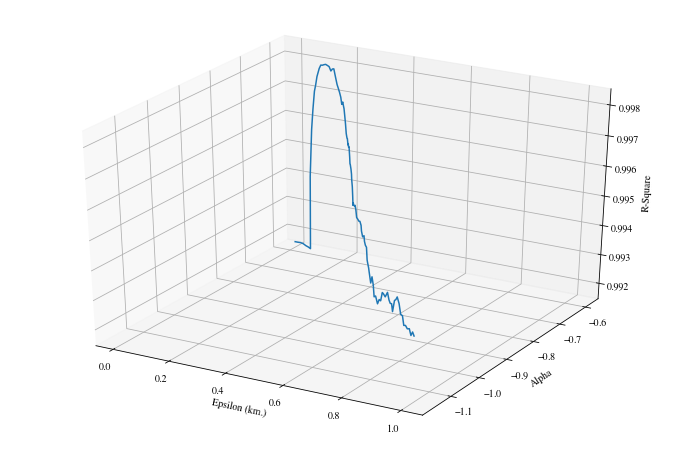

In [1231]:
fig,ax = plt.subplots(1,1,figsize=(12,8))

ax = plt.axes(projection='3d')

# Data for a three-dimensional line
eps_vals_workblocks = pareto_fit_df_workblocks['Eps_val']
alpha_vals_workblocks = pareto_fit_df_workblocks['alpha']
r_sq_vals_workblocks = pareto_fit_df_workblocks['r_square']

#ax.scatter3D(eps_vals_workblocks, alpha_vals_workblocks, r_sq_vals_workblocks, label='Workblocks')
ax.plot3D(eps_vals_workblocks, alpha_vals_workblocks, r_sq_vals_workblocks)

ax.set_xlabel('Epsilon (km.)')
ax.set_ylabel('Alpha')
ax.set_zlabel('R-Square')

#ax.legend()
plt.show()


#### Note: This 3d plot isn't so easy to read....maybe not. 